# Keras

To build our model we need to do a few steps:
- Download the MNIST dataset with consist of labeled handwritten images (28x28 px).
- Identify the feature that we are going to train the model on, which are just our image pixels.
- And let us use neural networks to build our model (LeNet-5 network architecture).
- The final step would to train our model and then test and validate how well we did.


## 1. Download MNIST dataset

Four files are available on this site, http://yann.lecun.com/exdb/mnist/:

* train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
* train-labels-idx1-ubyte.gz:  training set labels (28881 bytes) 
* t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes) 
* t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)

In [ ]:
from requests import get

def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)

In [ ]:
#download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
#download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
#download_file('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
#download_file('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

## Load the data

Load train and test data in memory

In [ ]:
# Update libraries
#!pip install seaborn==0.9.0

In [1]:
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

In [4]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

### Explore the data

It is always a good to do some data exploration before we start using it, find outliers, and decide if we need a preprocessing phase to uniform or augment it. And also to make sure that all the classes are covered by or more or less the same number of samples.


In [5]:
print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# of training images: 60000
# of test images: 10000


In [6]:
#train['features']=train['features'][:36000]

#### Display some images

In [7]:
def display_image(position):
    image = train['features'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, train['labels'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

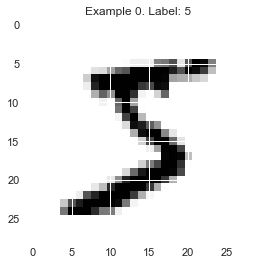

In [8]:
display_image(0)

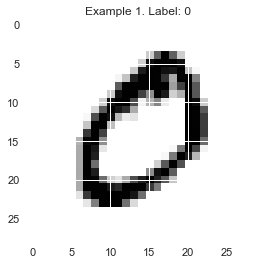

In [9]:
display_image(1)

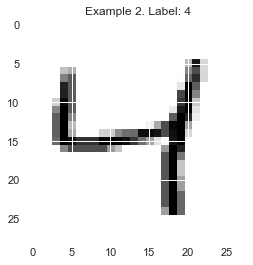

In [10]:
display_image(2)

#### Plot training data

In [11]:
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


### Split training data into training and validation

In [12]:
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)
#on fait en sortede mettre le randome state toujours à 0 pour travailler toujour sur le meme type de donnée

In [13]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

# of training images: 48000
# of validation images: 12000


## 2. Prepare our input features

The LeNet architecture accepts a 32x32 pixel images as input, mnist data is 28x28 pixels. We simply pad the images with zeros to overcome that.

In [14]:
train['features'][0].shape

(28, 28, 1)

In [15]:
# Pad images with 0s
train['features']      = np.pad(train['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
validation['features'] = np.pad(validation['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
test['features']       = np.pad(test['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(train['features'][0].shape))

#ici on ajoute du padding pour avoir une forme de 32x32 pour les images. 

Updated Image Shape: (32, 32, 1)


## 3. LeNet-5 implmentation

![lenet.png](https://raw.githubusercontent.com/MostafaGazar/mobile-ml/master/files/lenet.png)
>>> LeNet-5 Architecture. Credit: [LeCun et al., 1998](http://yann.lecun.com/exdb/publis/psgz/lecun-98.ps.gz)



**The following part is heavily inspired by** https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb

#### Input
    32x32x1 pixels image

#### Architecture
* **Convolutional #1** outputs 32x32x6
    * **Activation** any activation function, we will `relu`

* **Pooling #1** The output shape should be 14x14x6.

* **Convolutional #2** outputs 10x10x16.
    * **Activation** any activation function, we will `relu`

* **Pooling #2** outputs 5x5x16.
    * **Flatten** Flatten the output shape of the final pooling layer

* **Fully Connected #1** outputs 120
    * **Activation** any activation function, we will `relu`

* **Fully Connected #2** outputs 84
    * **Activation** any activation function, we will `relu`

* **Fully Connected (Logits) #3** outputs 10


In [16]:
#layers.Conv2D?

In [17]:
model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               69240     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [19]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

#pour mesurer un modèle il y a le loss et la metrics. Le loss est le cout de l'optimiseur, le but est de minimiser le loss. 

In [20]:
EPOCHS = 10 #combien de fois l'algorithme va traiter les données.
BATCH_SIZE = 128 #la finnesse avec laquelle le loss va se changer

In [21]:
X_train, y_train = train['features'], to_categorical(train['labels'])
X_validation, y_validation = validation['features'], to_categorical(validation['labels'])

train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE) #gère les batch_size. C'est une boucle for qui va donner le batch size a chaque fois qu'on lui demande 
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

In [22]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True, callbacks=[tensorboard])

# of training images: 48000
# of validation images: 12000


C:\Users\tomdu\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
375/375 [==============================] - 16s 39ms/step - loss: 0.5385 - accuracy: 0.8370 - val_loss: 0.0773 - val_accuracy: 0.9758
Epoch 2/10
375/375 [==============================] - 12s 31ms/step - loss: 0.0667 - accuracy: 0.9803 - val_loss: 0.0575 - val_accuracy: 0.9824
Epoch 3/10
375/375 [==============================] - 12s 32ms/step - loss: 0.0497 - accuracy: 0.9843 - val_loss: 0.0575 - val_accuracy: 0.9829
Epoch 4/10
375/375 [==============================] - 12s 32ms/step - loss: 0.0374 - accuracy: 0.9877 - val_loss: 0.0486 - val_accuracy: 0.9852
Epoch 5/10
375/375 [==============================] - 12s 31ms/step - loss: 0.0308 - accuracy: 0.9902 - val_loss: 0.0458 - val_accuracy: 0.9851
Epoch 6/10
375/375 [==============================] - 12s 32ms/step - loss: 0.0238 - accuracy: 0.9928 - val_loss: 0.0462 - val_accuracy: 0.9874
Epoch 7/10
375/375 [==============================] - 12s 32ms/step - loss: 0.0197 - accuracy: 0.9935 - val_loss: 0.0474 - val_accuracy:

In [23]:
score = model.evaluate(test['features'], to_categorical(test['labels']))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 7ms/step - loss: 0.0400 - accuracy: 0.9887
Test loss: 0.04004153236746788
Test accuracy: 0.9886999726295471


In [25]:
res_p = model.predict_classes(test['features'][:2])

C:\Users\tomdu\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [26]:
res_p[0]

7

In [27]:
np.argmax(res_p)

0